#E-commerce Customer review Rating

#Methods applied to acquire data
The Implementation of customer reviews or recommendation basically in our case required us the use of available dataset on reliable platform Kaggle. We downloaded and make of Amazon customer reviews dataset which includes different information identified as columns name: ID, productID, Review, Scores, Time summary and user Profile. The dataset is available on Kaggle. This NLP project acquire the use of a Global vector for word representation that we preprocess and create a word vectorized dictionary, available on Kaggle- https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation?select=glove.6B.50d.txt.



# Loading and Preprocessing Data

In [59]:
import numpy as np
import pandas as pd
from scipy import sparse

# from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.base import BaseEstimator, ClassifierMixin
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, SpatialDropout1D, GRU
from keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [23]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/E-commerce/Reviews.csv')

In [25]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Checking For Missing Values and Handling it

In [26]:
data.isnull().sum()/len(data)*100

Id                        0.000000
ProductId                 0.000000
UserId                    0.000000
ProfileName               0.002815
HelpfulnessNumerator      0.000000
HelpfulnessDenominator    0.000000
Score                     0.000000
Time                      0.000000
Summary                   0.004750
Text                      0.000000
dtype: float64

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [28]:
data = data.sample(n = 350000, random_state = 42)

In [29]:
import plotly.express as px

In [30]:
px.histogram(data, x = data['Score'])

In [31]:
# X_train, X_test, y_train, y_test = train_test_split(X_cv, y, test_size = 0.20, random_state = 0)

In [32]:
train = data[0:280000]
test = data[280000:]

,Text,Score
165256,Having tried a couple of other brands of glute...,5
231465,My cat loves these treats. If ever I can't fin...,5
427827,A little less than I expected. It tends to ha...,3
433954,"First there was Frosted Mini-Wheats, in origin...",2
70260,and I want to congratulate the graphic artist ...,5


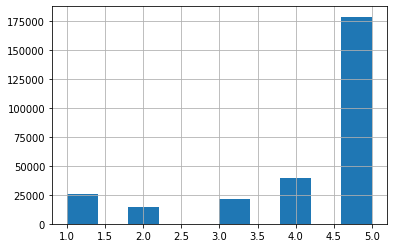

In [33]:
train = train[['Text', 'Score']]
train['Score'].hist();train.head()

converts categorical data into dummy or indicator variables

In [34]:
train = pd.get_dummies(train, columns = ['Score'])
train.head()

,Text,Score_1,Score_2,Score_3,Score_4,Score_5
165256,Having tried a couple of other brands of glute...,0,0,0,0,1
231465,My cat loves these treats. If ever I can't fin...,0,0,0,0,1
427827,A little less than I expected. It tends to ha...,0,0,1,0,0
433954,"First there was Frosted Mini-Wheats, in origin...",0,1,0,0,0
70260,and I want to congratulate the graphic artist ...,0,0,0,0,1


In [35]:
test = test[['Text', 'Score']]
test = pd.get_dummies(test, columns = ['Score'])
train.shape, test.shape

((280000, 6), (70000, 6))

So now I have a training set with 280,000 reviews and test set with 70,000. To make these models train super fast for exploration, I'm going to grab a sample and use that subsample in the initial trainings below. When I narrow it down to a final 'best' model, I'll retrain with the full data set to see what my accuracy becomes.

In [36]:
# set frac = 1. to use the entire sample
train_samp = train.sample(frac = .1, random_state = 42)
test_samp = test.sample(frac = .1, random_state = 42)
train_samp.shape, test_samp.shape

((28000, 6), (7000, 6))

# Neural Network

#Word Embeding


In [37]:
# I'm using GLoVe word vectors to get pretrained word embeddings
embed_size = 50 
# max number of unique words 
max_features = 20000
# max number of words from review to use
maxlen = 200

# File path
embedding_file = '/content/drive/MyDrive/Colab Notebooks/Classification/glove.6B.50d.txt'

# read in embeddings
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embedding_file))

In [38]:
len(embeddings_index)

400000

In [39]:
class_names = ['Score_1', 'Score_2', 'Score_3', 'Score_4', 'Score_5']
# Splitting off my y variable
y = train_samp[class_names].values

In [40]:
len(y)

28000

# Normalization, scaling and transformation of data
 Tokenize and padding the texts the texts

In [41]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_samp['Text'].values))
X_train = tokenizer.texts_to_sequences(train_samp['Text'].values)
X_test = tokenizer.texts_to_sequences(test_samp['Text'].values)
x_train = pad_sequences(X_train, maxlen = maxlen)
x_test = pad_sequences(X_test, maxlen = maxlen)

In [44]:
x_test.shape

(7000, 200)

In [45]:
word_index = tokenizer.word_index

nb_words = min(max_features, len(word_index))
# create a zeros matrix of the correct dimensions 
embedding_matrix = np.zeros((nb_words, embed_size))
missed = []
for word, i in word_index.items():
    if i >= max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        missed.append(word)

In [50]:
len(missed)

2903

In [52]:
# missed[0:10]

# Creation of deep learning model

In [65]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
# x = Bidirectional(LSTM(40, return_sequences=True))(x)
# x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'sigmoid')(conc)

model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'yelp_lstm_gru_weights.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Fit Model

In [66]:
model.fit(x_train, y, batch_size = 512, epochs = 20, validation_split = .1,
          callbacks=[earlystop, checkpoint])

Epoch 1/20
50/50 [==============================] - 4s 71ms/step - loss: 0.6029 - accuracy: 0.4204 - val_loss: 0.3733 - val_accuracy: 0.6514
Epoch 2/20
50/50 [==============================] - 3s 69ms/step - loss: 0.4452 - accuracy: 0.6005 - val_loss: 0.3701 - val_accuracy: 0.6514
Epoch 3/20
50/50 [==============================] - 3s 68ms/step - loss: 0.4278 - accuracy: 0.6179 - val_loss: 0.3657 - val_accuracy: 0.6514
Epoch 4/20
50/50 [==============================] - 3s 69ms/step - loss: 0.4121 - accuracy: 0.6274 - val_loss: 0.3628 - val_accuracy: 0.6514
Epoch 5/20
50/50 [==============================] - 3s 69ms/step - loss: 0.3990 - accuracy: 0.6303 - val_loss: 0.3589 - val_accuracy: 0.6514
Epoch 6/20
50/50 [==============================] - 3s 69ms/step - loss: 0.3903 - accuracy: 0.6344 - val_loss: 0.3550 - val_accuracy: 0.6514
Epoch 7/20
50/50 [==============================] - 3s 69ms/step - loss: 0.3856 - accuracy: 0.6294 - val_loss: 0.3523 - val_accuracy: 0.6514
Epoch 8/20
50

#Model Evaluation

In [67]:
y_test = model.predict([x_test], batch_size=1024)

In [68]:
model.evaluate(x_test, test_samp[class_names].values, verbose = 1, batch_size=1024)

7/7 [==============================] - 0s 21ms/step - loss: 0.3165 - accuracy: 0.6477


[0.3165019750595093, 0.6477142572402954]

In [69]:
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.53      0.07      0.12       640
           1       0.00      0.00      0.00       340
           2       0.31      0.02      0.03       505
           3       0.26      0.02      0.04      1025
           4       0.66      0.99      0.79      4490

    accuracy                           0.65      7000
   macro avg       0.35      0.22      0.20      7000
weighted avg       0.53      0.65      0.53      7000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Improving the Model
1- Specifying better embeddings Combining glove and fasttext embeddings to get better coverage would be a good start, but there's plenty of other tweaks to do here.

2 - We Added Bidirectional LSTMs function which are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

3- Ensembling models together It's a huge simplification, but the best model is often a combination of several models. A starting point would be combining the Naive Bayes and LSTM/GRU models through simple averaging. You can expand this a huge amount, but I'd have to set up a very rigorous cross validation scheme to avoid massively overfitting.


In [70]:
inp = Input(shape = (maxlen,))
x = Embedding(max_features, embed_size, weights = [embedding_matrix], trainable = True)(inp)
x = SpatialDropout1D(0.5)(x)
# Let add Bidirectional
x = Bidirectional(LSTM(40, return_sequences=True))(x)
x = Bidirectional(GRU(40, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)

conc = concatenate([avg_pool, max_pool])
outp = Dense(5, activation = 'sigmoid')(conc)

model = Model(inputs = inp, outputs = outp)
# patience is how many epochs to wait to see if val_loss will improve again.
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3)
checkpoint = ModelCheckpoint(monitor = 'val_loss', save_best_only = True, filepath = 'customer_review.hdf5')
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [71]:
# FIt model
model.fit(x_train, y, batch_size = 512, epochs = 20, validation_split = .1,
          callbacks=[earlystop, checkpoint])

Epoch 1/20
50/50 [==============================] - 118s 2s/step - loss: 0.4905 - accuracy: 0.5430 - val_loss: 0.3600 - val_accuracy: 0.6514
Epoch 2/20
50/50 [==============================] - 111s 2s/step - loss: 0.3679 - accuracy: 0.6365 - val_loss: 0.3582 - val_accuracy: 0.6514
Epoch 3/20
50/50 [==============================] - 111s 2s/step - loss: 0.3684 - accuracy: 0.6287 - val_loss: 0.3473 - val_accuracy: 0.6518
Epoch 4/20
50/50 [==============================] - 110s 2s/step - loss: 0.3575 - accuracy: 0.6314 - val_loss: 0.3222 - val_accuracy: 0.6554
Epoch 5/20
50/50 [==============================] - 110s 2s/step - loss: 0.3381 - accuracy: 0.6327 - val_loss: 0.3075 - val_accuracy: 0.6650
Epoch 6/20
50/50 [==============================] - 110s 2s/step - loss: 0.3226 - accuracy: 0.6486 - val_loss: 0.2980 - val_accuracy: 0.6700
Epoch 7/20
50/50 [==============================] - 110s 2s/step - loss: 0.3125 - accuracy: 0.6551 - val_loss: 0.2943 - val_accuracy: 0.6739
Epoch 8/20
50

In [72]:
y_test = model.predict([x_test], batch_size=1024)

In [73]:
model.evaluate(x_test, test_samp[class_names].values, verbose = 1, batch_size=1024)

7/7 [==============================] - 9s 1s/step - loss: 0.2604 - accuracy: 0.7126


[0.26035434007644653, 0.7125714421272278]

In [74]:
v = metrics.classification_report(np.argmax(test_samp[class_names].values, axis = 1),np.argmax(y_test, axis = 1))
print(v)

              precision    recall  f1-score   support

           0       0.53      0.71      0.61       640
           1       0.00      0.00      0.00       340
           2       0.31      0.26      0.28       505
           3       0.42      0.21      0.28      1025
           4       0.80      0.93      0.86      4490

    accuracy                           0.71      7000
   macro avg       0.41      0.42      0.41      7000
weighted avg       0.65      0.71      0.67      7000



In [104]:
def predict_rating(predicted):
  max = predicted[0]
  rating = 0
  for i in range(len(predicted)):
    if predicted[i] >= max:
      max = predicted[i]
      rating = i + 1
  print('star: ' + str(rating))

# Test Model

In [110]:
Example = tokenizer.texts_to_sequences(['I hate this product it is bad the most to the product'])
examp = pad_sequences(Example, maxlen = maxlen)

In [111]:
predict_rating((model.predict(examp))[0])

star: 1


# Convert the model into TensorflowJs 

In [114]:
pip install tensorflowjs

     |████████████████████████████████| 71kB 3.7MB/s 
     |████████████████████████████████| 112kB 7.2MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [115]:
import tensorflowjs as tfjs
import tensorflow as tf
import sys
import keras

In [116]:
tfjs.converters.save_keras_model(model,'model')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.

